In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from copy import deepcopy
from scipy.optimize import curve_fit
from lmfit import Minimizer, Parameters, report_fit
import seaborn as sns

sns.set(color_codes=True, style="white")

### Load Data

In [2]:
folder = "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-in-HOPS_condensates/paper_figure_plots/interaction_kinetics_lncRNA"
label1 = "THOR, 2x"
label2 = "THOR$\Delta$, 2x"
fname1 = "colocalization_AIO_concat-THOR_2x.csv"
fname2 = "colocalization_AIO_concat-THORdel_2x.csv"
color_1 = "#0C4DA2"
color_2 = "#4C90D2"
palette = [color_1, color_2]
os.chdir(folder)

In [3]:
df1 = pd.read_csv(fname1)
df2 = pd.read_csv(fname2)

### Functions

In [4]:
def get_dwell_times(array_in_condensate, array_trackID):
    # Find the indices where the array changes from False to True or vice versa
    change_indices_condensate = (
        np.where(array_in_condensate[:-1] != array_in_condensate[1:])[0] + 1
    )

    # Find the indices where the trackID changes
    change_indices_trackID = np.where(array_trackID[:-1] != array_trackID[1:])[0] + 1

    # Combine the change indices from both arrays
    change_indices = np.unique(
        np.concatenate((change_indices_condensate, change_indices_trackID))
    )

    # Add the start and end indices to the change_indices array
    change_indices = np.concatenate(([0], change_indices, [len(array_in_condensate)]))

    # Calculate the durations of each True event
    dwell_times = []
    for i in range(len(change_indices) - 1):
        if array_in_condensate[change_indices[i]]:
            dwell_times.append(change_indices[i + 1] - change_indices[i])

    return np.array(dwell_times)

### Dwell time distributions

In [5]:
dwell_times_1 = (
    get_dwell_times(df1["InCondensate"].to_numpy(), df1["RNA_trackID"].to_numpy()) * 0.1
)  # unit s
dwell_times_2 = (
    get_dwell_times(df2["InCondensate"].to_numpy(), df2["RNA_trackID"].to_numpy()) * 0.1
)  # unit s
data = pd.concat(
    [
        pd.DataFrame({"dwell_time": dwell_times_1, "label": label1}),
        pd.DataFrame({"dwell_time": dwell_times_2, "label": label2}),
    ],
    ignore_index=True,
)

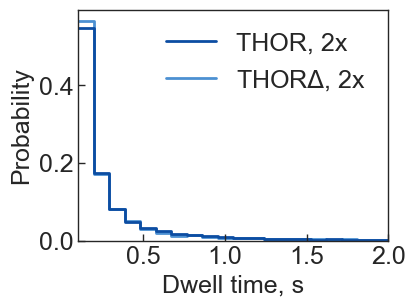

In [6]:
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=data,
    x="dwell_time",
    hue="label",
    palette=palette,
    bins=20,
    binrange=(0.1, 2),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    fill=False,
    # cumulative=True,
)
plt.xlim(0.1, 2)
sns.move_legend(ax, 1, title=None, frameon=False, fontsize=18)
plt.xlabel("Dwell time, s", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "dwell-histo.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)

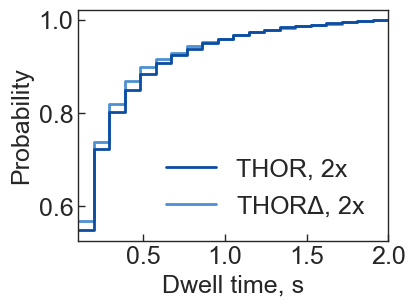

In [7]:
plt.figure(figsize=(4, 3))
ax = sns.histplot(
    data=data,
    x="dwell_time",
    hue="label",
    palette=palette,
    bins=20,
    binrange=(0.1, 2),
    stat="probability",
    common_norm=False,
    lw=2,
    element="step",
    fill=False,
    cumulative=True,
)
plt.xlim(0.1, 2)
sns.move_legend(ax, 4, title=None, frameon=False, fontsize=18)
plt.xlabel("Dwell time, s", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="both",
    which="major",
    labelsize=18,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.gca().set_axisbelow(False)
plt.gca().tick_params(axis="both", which="major", labelsize=18)
plt.savefig(
    "dwell-cdf.png",
    format="png",
    bbox_inches="tight",
    dpi=300,
)